## Exploration for Sentiment Analysis

Creates a Word Cloud of each restaurant's reviews, vectorized with BoW

#### To-Do

- Overall word counts
- Sentiment color coding

### Import and Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import re
import nltk
import statistics
import random

#Preprocessing
from utils import pipeline_v1e
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from textblob import TextBlob
sent_tokenizer = PunktSentenceTokenizer()

#Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#Classification and Metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from tqdm import tqdm

In [2]:
reviews = pd.read_csv('data_hyderabad/10k_reviews.csv')
reviews.sample(5)

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
9642,Hyderabadi Daawat,Kanishka Saini,I went to this restaurant with very high hopes...,4,"24 Reviews , 19 Followers",1/5/2019 12:43,0
9532,Desi Bytes,Anvesha Tiwari,Food taste was good and quality was also nice.,4,"6 Reviews , 11 Followers",7/22/2018 14:43,0
4325,The Foodie Monster Kitchen,Veera,"Nice place for Shawarma, rice bowls and chicke...",5,2 Reviews,1/4/2019 21:22,0
813,Hyper Local,Soumodip Pal,Good Place to fun with your team.\nNice DJ #za...,4,"4 Reviews , 4 Followers",5/10/2019 19:33,2
7146,Eat India Company,Rohith,#Good food#goodambiance #greatservice #pocket ...,4,"1 Review , 1 Follower",10/25/2018 19:17,0


In [3]:
reviews.drop(['Reviewer', 'Metadata', 'Time', 'Pictures', 'Rating'], axis=1, inplace=True)
reviews.dropna(subset=["Review"], inplace=True)
reviews.sample(5)

,Restaurant,Review
7515,Royal Spicy Restaurant,"""Not so spicy, but totally lip smaking”\n\nI w..."
9928,Chinese Pavilion,Soups were excellent.\nSatay was ok.\nChopsuey...
8591,Momos Delight,Big fan of kurkure chicken momos served here. ...
9919,Chinese Pavilion,"We book a table at Chinese pavilion, as name s..."
5560,Cafe Eclat,"I don't know why this place is rated 3.9, it e..."


In [4]:
# Grouping the reviews per restaurant for analysis
reviews_per_restaurant = reviews.groupby('Restaurant')['Review'].apply(list).to_dict()

In [5]:
# Adding the count of reviews to the dataframe, and converting the reviews into a list
restaurants_df = pd.DataFrame({
    "Restaurant": list(reviews_per_restaurant.keys()),
    "Reviews": list(reviews_per_restaurant.values()),
    "Num_Reviews": [len(reviews) for reviews in reviews_per_restaurant.values()],
    "Avg_Review_Length": [sum(len(review) for review in reviews) / len(reviews) for reviews in reviews_per_restaurant.values()]
})

# Sorting by number of reviews for cleaner visualization
restaurants_df = restaurants_df.sort_values(by="Num_Reviews", ascending=False)

### Analysing the Reviews column

In [6]:
print("Total restaurants:", len(reviews_per_restaurant))
print("Sample:")

# Checking 5 random restaurants
sampled_items = random.sample(list(reviews_per_restaurant.items()), 5)

for name, reviews in sampled_items:
    print(f"Restaurant: {name}  |  Number of Reviews: {len(reviews)}")

Total restaurants: 100
Sample:
Restaurant: Frio Bistro  |  Number of Reviews: 100
Restaurant: Absolute Sizzlers  |  Number of Reviews: 100
Restaurant: Faasos  |  Number of Reviews: 100
Restaurant: Driven Cafe  |  Number of Reviews: 100
Restaurant: The Glass Onion  |  Number of Reviews: 100


In [7]:
# Statistics for number of reviews per restaurant
num_reviews_per_restaurant = [len(reviews) for reviews in reviews_per_restaurant.values()]

print("Number of Reviews per Restaurant:")
print(f"Minimum: {np.min(num_reviews_per_restaurant)}")
print(f"Maximum: {np.max(num_reviews_per_restaurant)}")
print(f"Average: {np.mean(num_reviews_per_restaurant):.2f}")

Number of Reviews per Restaurant:
Minimum: 77
Maximum: 100
Average: 99.55


In [8]:
# Statistics for length of each review
review_lengths = [len(review) for reviews in reviews_per_restaurant.values() for review in reviews]

print("Length of Reviews:")
print(f"Minimum length: {np.min(review_lengths)} characters")
print(f"Maximum length: {np.max(review_lengths)} characters")
print(f"Average length: {np.mean(review_lengths):.2f} characters")

Length of Reviews:
Minimum length: 1 characters
Maximum length: 5212 characters
Average length: 279.77 characters


In [9]:
# Histogram for the Number of Reviews per Restaurant
num_reviews_bins = np.histogram_bin_edges(restaurants_df["Num_Reviews"], bins=20)
restaurants_df["Num_Reviews_Bin"] = pd.cut(restaurants_df["Num_Reviews"], bins=num_reviews_bins)

# Group restaurants by each bin to get hover text with restaurant names in each bin
num_reviews_hover_text = restaurants_df.groupby("Num_Reviews_Bin").apply(
    lambda group: "<br>".join(group["Restaurant"])
).reindex(pd.IntervalIndex.from_breaks(num_reviews_bins, closed="left")).fillna("")

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=restaurants_df["Num_Reviews"],
    xbins=dict(start=num_reviews_bins[0], end=num_reviews_bins[-1], size=(num_reviews_bins[1] - num_reviews_bins[0])),
    name="Number of Reviews per Restaurant",
    hovertemplate="<b>Bin:</b> %{x}<br><b>Count:</b> %{y}<br><b>Restaurants:</b><br>%{customdata}",
    customdata=num_reviews_hover_text,
    marker_color="lightsalmon"
))

# Histogram for Length of Reviews
# Flatten the list of reviews and calculate review lengths
review_lengths = [len(review) for reviews in reviews_per_restaurant.values() for review in reviews]
review_lengths_bins = np.histogram_bin_edges(review_lengths, bins=20)
review_lengths_hover_text = pd.cut(pd.Series(review_lengths), bins=review_lengths_bins).value_counts().sort_index()

fig.add_trace(go.Histogram(
    x=review_lengths,
    xbins=dict(start=review_lengths_bins[0], end=review_lengths_bins[-1], size=(review_lengths_bins[1] - review_lengths_bins[0])),
    name="Length of Reviews",
    hovertemplate="<b>Bin:</b> %{x}<br><b>Count:</b> %{y}",
    marker_color="palevioletred"
))

# Update layout for the plot
fig.update_layout(
    title="Distribution of Number of Reviews and Review Lengths per Restaurant",
    xaxis_title="Values",
    yaxis_title="Frequency",
    barmode="overlay",
    hovermode="closest"
)

fig.show()

C:\Users\msard\AppData\Local\Temp\ipykernel_4820\260005965.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_reviews_hover_text = restaurants_df.groupby("Num_Reviews_Bin").apply(
C:\Users\msard\AppData\Local\Temp\ipykernel_4820\260005965.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  num_reviews_hover_text = restaurants_df.groupby("Num_Reviews_Bin").apply(


Insight: 
- There are 100 restaurants with non-empty reviews
- Most restaurants have 100 reviews, except 3 (that have 77, 85, 98)
- Most restaurants have reviews of below 260 characters, but there are outliers with over 3000 characters, one having 5212.

### Word Cloud and Word Frequency
We are applying word cloud only to the reviews of a given restaurant instead of the whole corpus due to memory constraints.

In [10]:
def generate_word_cloud_from_reviews(reviews_list):
    '''
    Generates a word cloud from a list of reviews
    Input: reviews_list (list of str): List of review texts
    Output: PIL.Image: Word cloud image generated from the reviews
    '''
    reviews_df = pd.DataFrame(reviews_list, columns=["Review"])

    # Vectorize the reviews to get trigrams
    trigram_bow_vectorizer = CountVectorizer(ngram_range=(1, 3), token_pattern=r"(?u)\b\w+\b")
    reviews_bow_td_matrix = trigram_bow_vectorizer.fit_transform(reviews_df["Review"]).toarray()
    reviews_bow_word_list = trigram_bow_vectorizer.get_feature_names_out()

    # Calculate word frequencies
    reviews_raw_vocabulary = pipeline_v1e.word_freq_calculator(reviews_bow_td_matrix, reviews_bow_word_list, df_output=False)
    
    # Generate the word cloud
    wc = WordCloud(background_color="white", max_words=120, width=220, height=220, color_func=lambda *args, **kwargs: (0, 0, 0))
    wc.generate_from_frequencies(reviews_raw_vocabulary)
    
    return wc.to_image()

In [11]:
# Dictionary to store word cloud images for each name
word_cloud_images = {}

for name, reviews_list in reviews_per_restaurant.items():
    word_cloud_images[name] = generate_word_cloud_from_reviews(reviews_list)

# Now word_cloud_images[name] will hold the word cloud image for each name


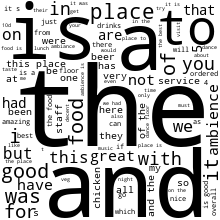

In [12]:
word_cloud_images['10 Downing Street']

In [13]:
def restaurant_term_frequencies(reviews_list):
    '''
    Calculates term frequencies from a list of reviews.
    Input: reviews_list (list of str): List of review texts
    Output: dataframe containing term frequencies
    '''
    # Convert the list of reviews into a DataFrame
    reviews_df = pd.DataFrame(reviews_list, columns=["Review"])

    # Vectorize the reviews to get trigrams
    trigram_bow_vectorizer = CountVectorizer(ngram_range=(1, 3), token_pattern=r"(?u)\b\w+\b")
    reviews_bow_td_matrix = trigram_bow_vectorizer.fit_transform(reviews_df["Review"]).toarray()
    reviews_bow_word_list = trigram_bow_vectorizer.get_feature_names_out()

    # Calculate word frequencies
    reviews_raw_vocabulary_df = pipeline_v1e.word_freq_calculator(reviews_bow_td_matrix, reviews_bow_word_list, df_output=True)

    return reviews_raw_vocabulary_df

In [14]:
term_frequencies = {}

for name, reviews_list in reviews_per_restaurant.items():
    term_frequencies[name] = restaurant_term_frequencies(reviews_list)

# pipeline_v1e.plot_term_frequency(term_frequencies['10 Downing Street'], 20, "Term Frequencies from Reviews", show=True)

In [19]:
import pandas as pd

# Assuming 'data_dict' is your dictionary of DataFrames
# Concatenate all DataFrames in the dictionary into a single DataFrame
combined_df = pd.concat(term_frequencies.values(), ignore_index=True)

# Group by 'words' and calculate the sum of 'frequency' for each unique word
result_df = combined_df.groupby('words', as_index=False)['frequency'].sum()

# Sort by frequency in descending order (optional, for better readability)
result_df = result_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)

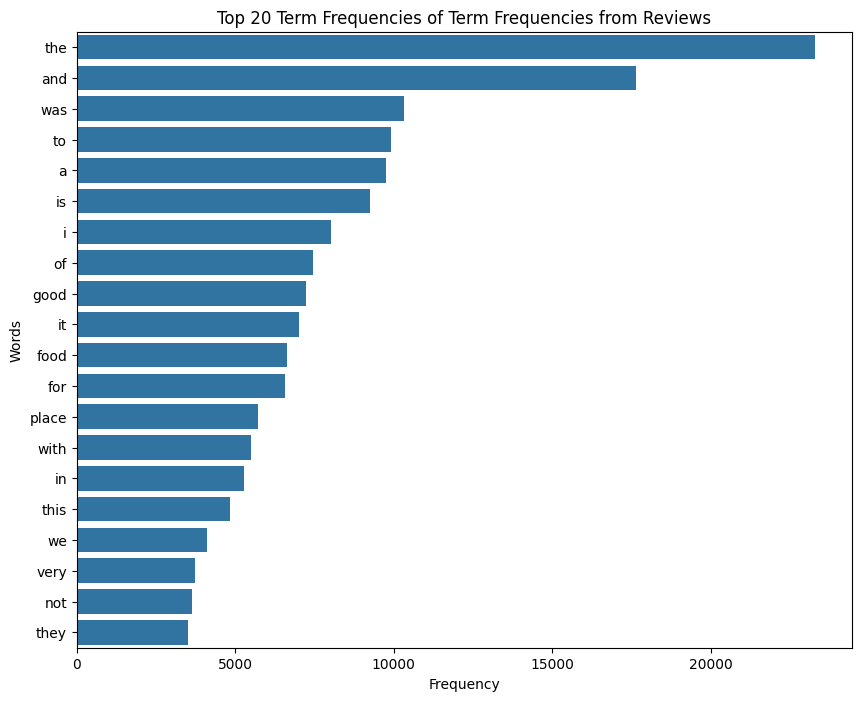

In [21]:
pipeline_v1e.plot_term_frequency(result_df, 20, "Term Frequencies from Reviews", show=False)

Insights:
- The only non-stopwords in the combined top 20 tokens are "good", "food" and "place". The appearance of "good" in particular may indicate an overall positive polarity.